# Linear models

In this section, we take advantage of some of `scikit-learn` powerful features such as the `pipeline` to run backtests with some learning. This is an extension of the industry momentum backtests presented in the previous section. 

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from skfin.plot import heatmap, line
from tqdm.auto import tqdm

## Ridge / Lasso / Elastic net

For a Ridge regression, the betas $\langle \beta_1, ..., \beta_p \rangle$ are chosen to minimize 
$$
\frac{1}{2} \sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^p \beta_j^2. 
$$
The Ridge regression generally provides more stable and accurate estimates than a standard linear regression. 

For the Lasso regression, the betas $\langle \beta_1,...,\beta_p \rangle$ are chosen to minimize 
$$
\frac{1}{2} \sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^p |\beta_j|. 
$$
The Lasso tends to promote sparse and stable models that can be more easily interpretable. 


Finally, for the Elastic net: the betas $\langle \beta_1,... ,\beta_p \rangle$ are chosen to minimize 
$$
	\frac{1}{2} \sum_{i=1}^N (y_i - \beta_0 - \sum_{j=1}^p x_{ij} \beta_j)^2 + \lambda \sum_{j=1}^p [(1-\alpha) \beta_j^2 + \alpha |\beta_j|]. 
$$

The lasso penalty is not very good at selecting individual predictors when they are strong and closely related, while the ridge penalty tends to make the coefficients of related variables similar. The elastic net finds a middle ground by potentially averaging the impact of closely related features while encouraging a simpler model overall.

To give an example, we use a diabetes dataset provided by `sklearn`.

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import enet_path, lasso_path

In [3]:
X, y = load_diabetes(return_X_y=True, as_frame=True)

In [4]:
X /= X.std(axis=0)
eps = 5e-3
l1_ratio = 0.5

alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)
alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio)

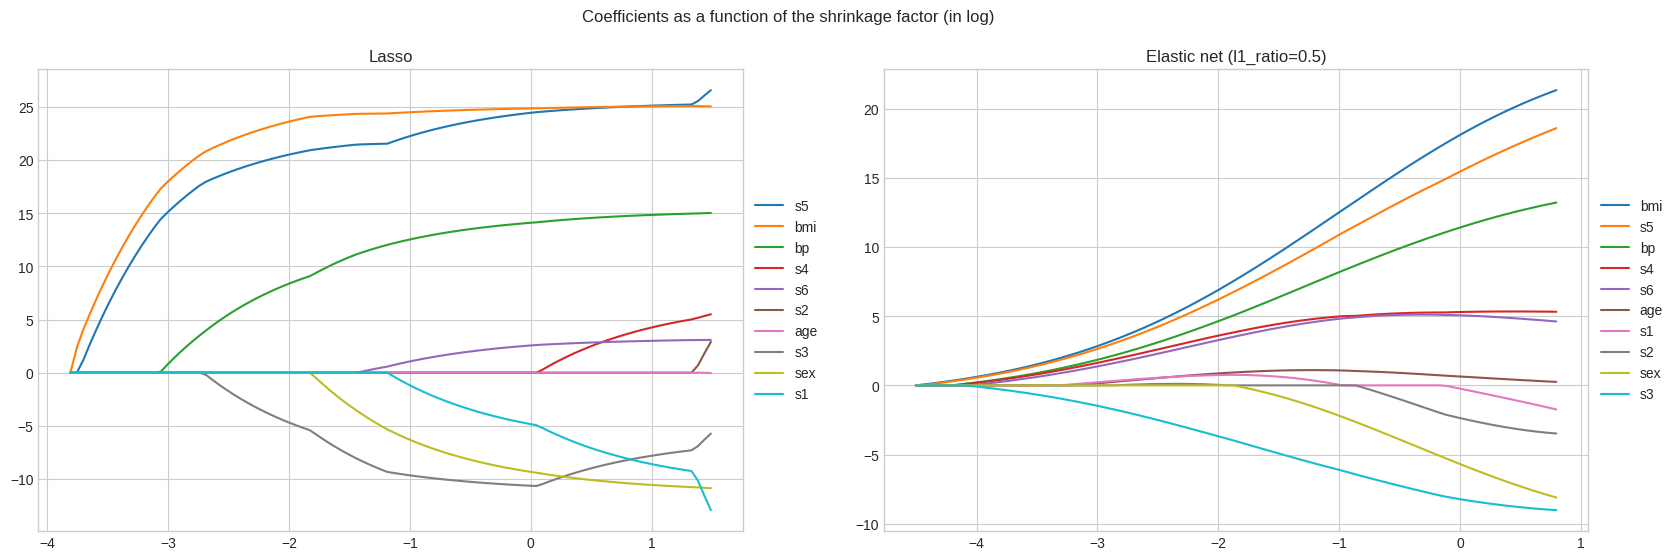

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
fig.suptitle("Coefficients as a function of the shrinkage factor (in log)")
line(
    pd.DataFrame(coefs_lasso.T, -1 * np.log(alphas_lasso), columns=X.columns),
    title="Lasso",
    ax=ax[0],
)
line(
    pd.DataFrame(coefs_enet.T, -1 * np.log(alphas_enet), columns=X.columns),
    title=f"Elastic net (l1_ratio={l1_ratio})",
    ax=ax[1],
)

See more discussion in 

> Hastie, Trevor, et al. *The elements of statistical learning: data mining, inference, and prediction.* Vol. 2. New York: springer, 2009.

## Revisiting the industry backtest with linear models

In the `Industry momentum` section, we introduced a feature `X` as 12-month trailing past returns and target `y` as the one-month forward return. For $N$ industries (e.g. $N=12$), `X` and `y` are vectors of size $N$. In this section, we are interested in fitting linear models (potentially with regularisation à la Ridge, Lasso or Elastic Net) such that 

$$ y = B X, $$ 

where $B$ is a matrix of size $[N \times N]$. (In this equation, we ignore intercept terms which are generally small.) This equation falls into two lines of research: 

- in classic Econometrics, this is called a Vector Autoregressive (VAR) model (.e.g see the [wikipedia article](https://en.wikipedia.org/wiki/Vector_autoregression)). 

- in Machine-learning, this is often called a `multioutput` model. 

The interpretation of this model in the context of industry timing is that it captures cross-industry effect: 

- for instance, a increasing trend on oil prices (which is positive for the Energy stocks) might be a negative predictor for sectors that use oil as input (e.g. Manufacturing)

Such VAR/multioutput models will pick up the positive lead-lag correlations across industries and therefore potentially enrich the simple `Industry momentum` strategy that we introduced in the previous section.

### Scikit-learn Pipeline and Multi-output

From the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), the definition of a `sklearn` pipeline is: 

> Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. 

Estimator like linear regressions or `Ridge` regressions have a `multiouput` argument which allows for a joint fit of multiple target at the same time. This provides a similar behavior to a `sklearn` transormations. Moreover: 

- in the pipelines that we are building, the last step is the `MeanVariance` class that produces the holdings;  

- in the `sklearn` pipelines, all the steps except for the last one must be transformations; 

- despite formally not having a `transform` function, the `multioutput` linear estimators (such as `Ridge` and `Lasso`) are transformations of a vector `X` of size $N$ into a vector `y` of size $N$. 

In the following module, we extend the estimators that we will be using to have such `transform` property. 

In [6]:
%%writefile ../skfin/estimators.py
from lightgbm.sklearn import LGBMRegressor
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neural_network import MLPRegressor


def add_transform_method(cls):
    """
    Decorator to add a 'transform' method to a class that uses the 'predict' method.
    """
    def transform(self, X):
        return self.predict(X)
        
    cls.transform = transform
    return cls

@add_transform_method
class LinearRegression(LinearRegression):
    pass

@add_transform_method
class Ridge(Ridge):
    pass

@add_transform_method
class RidgeCV(RidgeCV):
    pass

@add_transform_method
class MLPRegressor(MLPRegressor):
    pass

@add_transform_method
class MultiOutputRegressor(MultiOutputRegressor):
    pass


class MultiLGBMRegressor(BaseEstimator):
    """
    Multi-output extension of the lightgbm regressor as a transform class
    get_params and set_params attributes necessary for cloning the class
    """

    def __init__(self, **kwargs):
        if "n_jobs" in kwargs.keys():
            kwargs["n_jobs"] = 1
        else:
            kwargs = {"n_jobs": 1, **kwargs}
        self.m = MultiOutputRegressor(LGBMRegressor(**kwargs))

    def get_params(self, deep=True):
        return self.m.estimator.get_params(deep=deep)

    def set_params(self, **kwargs):
        if "n_jobs" in kwargs.keys():
            kwargs["n_jobs"] = 1
        else:
            kwargs = {"n_jobs": 1, **kwargs}
        return self.m.estimator.set_params(**kwargs)

    def fit(self, X, y):
        return self.m.fit(X, y)

    def transform(self, X):
        return self.m.transform(X)

Overwriting ../skfin/estimators.py


### Linear Regression

We first load the data and the main custom functions to run a backtest. 

In [7]:
from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.mv_estimators import MeanVariance

returns_data = load_kf_returns(cache_dir="data")

ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]


def transform_X(df, window=12):
    return df.rolling(window=window).mean()


def transform_y(df):
    return df.shift(-1)


features = transform_X(ret)
target = transform_y(ret)

INFO:skfin.dataloaders.cache:Loading from cache : data/12_Industry_Portfolios


As a reference, we re-compute the pnl of a simple `Industry momentum` strategy.

In [8]:
pnls = [
    Backtester(MeanVariance(), name="Industry momentum").train(features, target, ret)
]

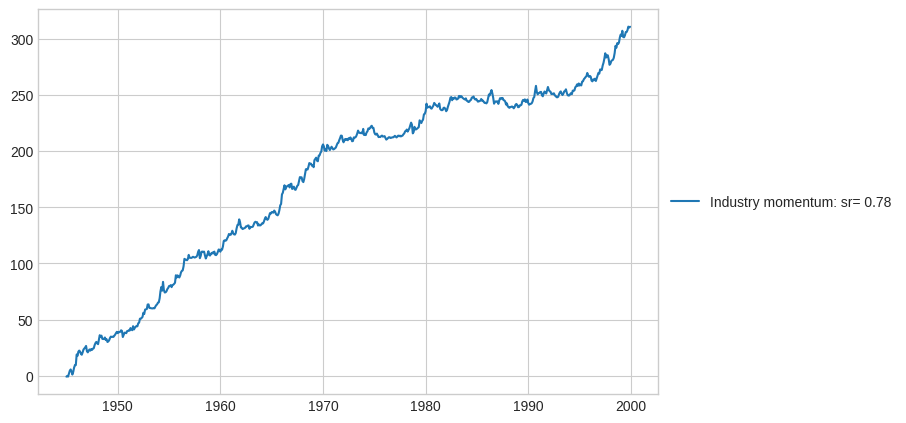

In [9]:
line(pnls, cumsum=True)

We now load the functions that are specific to building `sklearn` pipelines. 

In [10]:
from skfin.estimators import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

In the following simple pipeline, there are two steps: 

- the first step is a simple `multioutput` linear regression that produces fitted predictions for each industry

- the second step takes these predictors and scales them as holdings with a mean-variance optimisation (with the `MeanVariance` class introduced earlier. 

In [11]:
estimator = make_pipeline(LinearRegression(), MeanVariance())

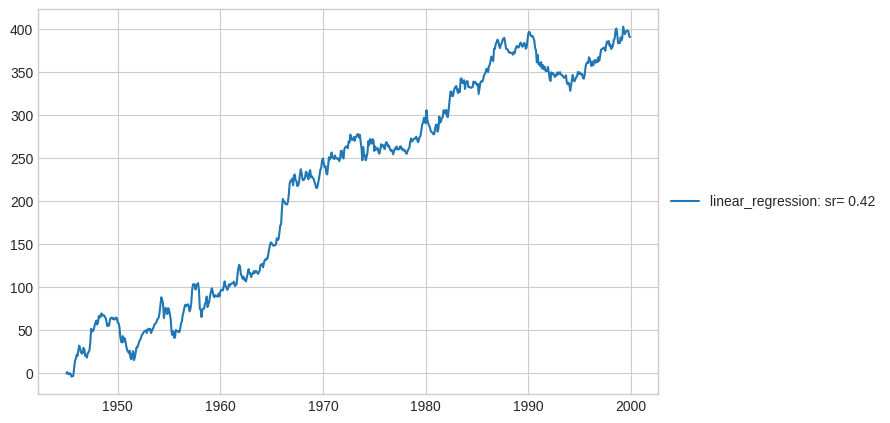

In [12]:
m = (
    Backtester(estimator, name="linear_regression")
    .compute_holdings(features, target)
    .compute_pnl(ret)
)
pnls += [m.pnl_]
line(m.pnl_, cumsum=True)

The linear regression fits an intercept and some coefficients. 

In [13]:
ols_ = m.estimators_[0].named_steps["linearregression"]
coef_ = ols_.coef_
intercept_ = ols_.intercept_
vec = ret.mean().values
np.allclose(ols_.predict(vec[None, :]), coef_.dot(vec) + intercept_)

True

In [14]:
coefs_ = [m.named_steps["linearregression"].coef_ for m in m.estimators_]
coefs_mean = pd.DataFrame(sum(coefs_) / len(coefs_), ret.columns, ret.columns).T

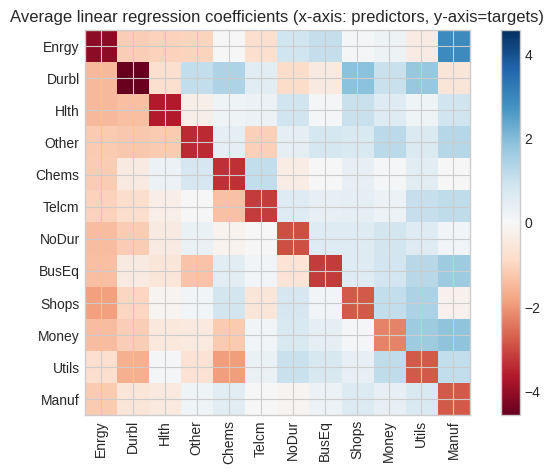

In [15]:
heatmap(
    coefs_mean.loc[
        coefs_mean.mean(1).sort_values().index, coefs_mean.mean(1).sort_values().index
    ],
    title="Average linear regression coefficients (x-axis: predictors, y-axis=targets)",
)

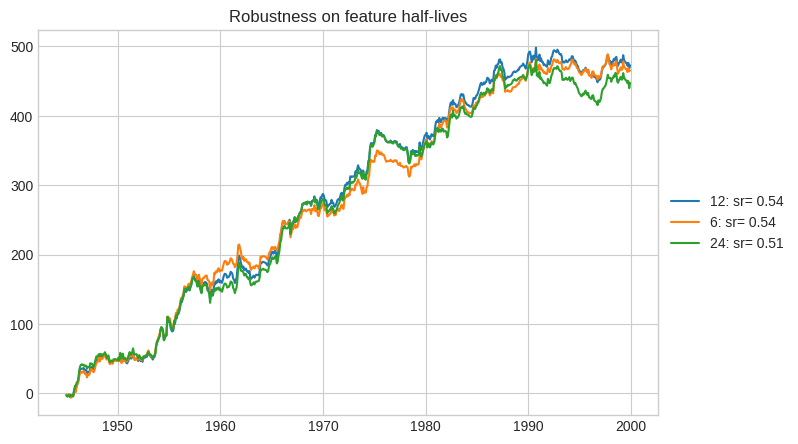

In [16]:
pnls_ = {}
for hl in [6, 12, 24]:
    features_ = ret.ewm(halflife=hl).mean().fillna(0)
    pnls_[hl] = Backtester(estimator).train(features_, target, ret)
line(pnls_, cumsum=True, title="Robustness on feature half-lives")

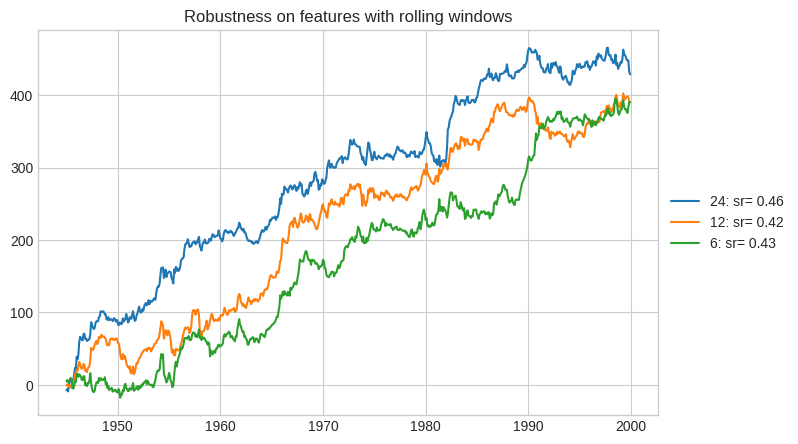

In [17]:
pnls_ = {}
for hl in [6, 12, 24]:
    features_ = ret.rolling(window=hl).mean().fillna(0)
    pnls_[hl] = Backtester(estimator).train(features_, target, ret)
line(pnls_, cumsum=True, title="Robustness on features with rolling windows")

### Ridge

Given that the `Ridge` regression applies a constraint across features, each feature needs to be properly rescaled, which is done here with `StandardScalar`.

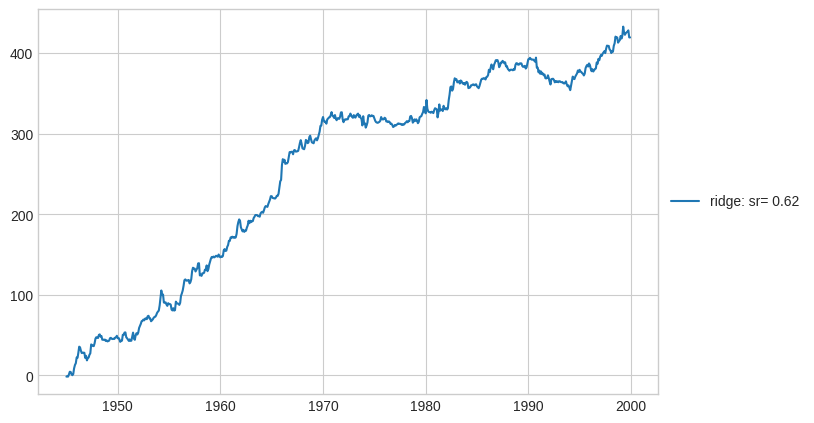

In [18]:
estimator = make_pipeline(StandardScaler(with_mean=False), Ridge(), MeanVariance())
m = (
    Backtester(estimator, name="ridge")
    .compute_holdings(features, target)
    .compute_pnl(ret)
)
pnls += [m.pnl_]
line(m.pnl_, cumsum=True)

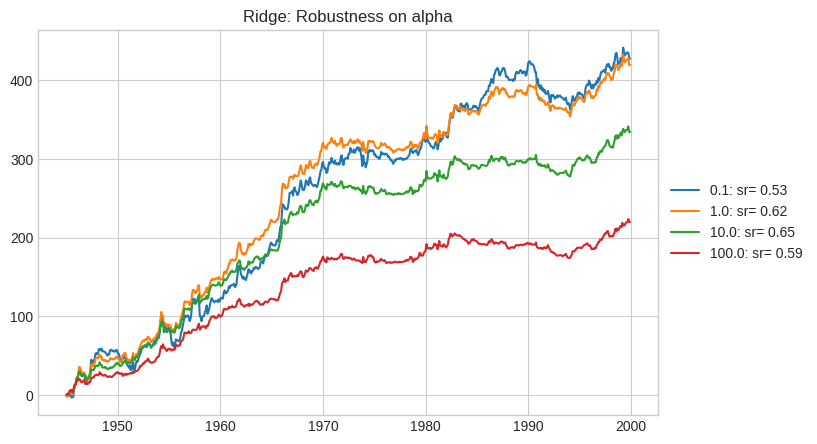

In [19]:
pnls_ = {}
for alpha in [0.1, 1, 10, 100]:
    estimator_ = make_pipeline(
        StandardScaler(with_mean=False), Ridge(alpha=alpha), MeanVariance()
    )
    pnls_[alpha] = Backtester(estimator_).train(features, target, ret)
line(pnls_, cumsum=True, title="Ridge: Robustness on alpha")

### Ridge with feature expansion

We can expand the set of features by using polynomial transfomrs with `PolynomialFeatures`.

In [20]:
PolynomialFeatures(degree=2).fit_transform(ret.iloc[:10]).shape

(10, 91)

Number of new features: intercept, initial features (=12), squared features (12), all cross features of degree 1 (=6*11): 

In [21]:
estimator = make_pipeline(
    StandardScaler(with_mean=False),
    PolynomialFeatures(degree=2),
    Ridge(alpha=100),
    MeanVariance(),
)

In [22]:
print(f"Number of features generated by degree=2: {1 + 12 + 12 + 6 * 11}")

Number of features generated by degree=2: 91


In [23]:
pnls += [
    Backtester(estimator, name="ridge_with_feature_expansion").train(
        features_, target, ret
    )
]
# line(m.pnl_, cumsum=True)

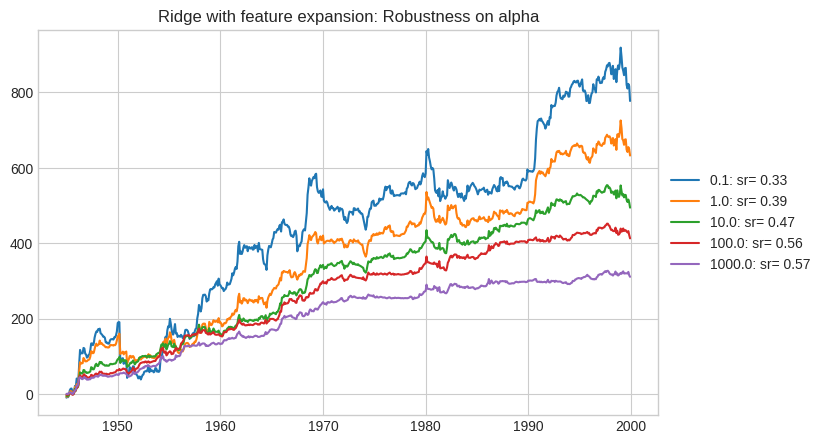

In [24]:
pnls_ = {}
for alpha in [0.1, 1, 10, 100, 1000]:
    estimator_ = make_pipeline(
        StandardScaler(with_mean=False),
        PolynomialFeatures(degree=2),
        Ridge(alpha=alpha),
        MeanVariance(),
    )
    pnls_[alpha] = Backtester(estimator_).train(features_, target, ret)
line(pnls_, cumsum=True, title="Ridge with feature expansion: Robustness on alpha")

Putting all the types of linear predictors together, we can compare the cumulative pnls in the graph below.

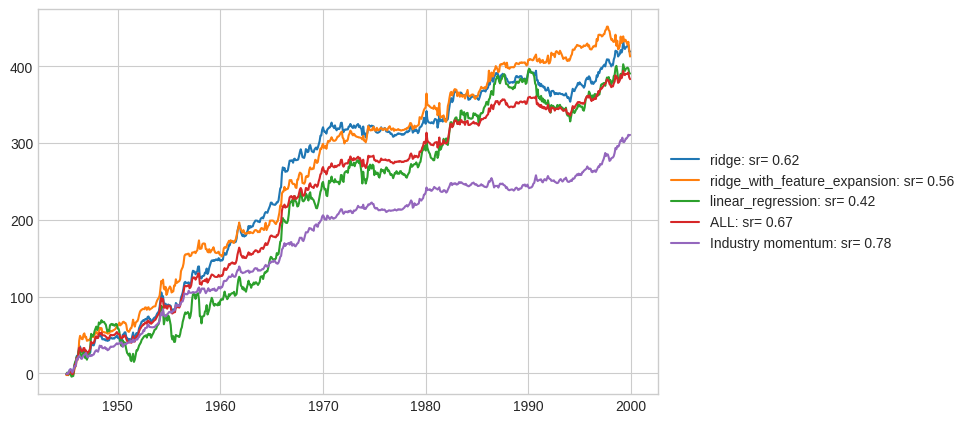

In [25]:
line(pd.concat(pnls, axis=1).assign(ALL=lambda x: x.mean(axis=1)), cumsum=True)